In [1]:
import uproot
import pandas as pd
import numpy as np
import argparse
from copy import copy
from utils.const import *
from utils.physics import *
from scipy.stats import skewnorm
import sys

In [3]:
file = uproot.open('quick_delta_ana/pi0_skim8_005038.root')

In [4]:
detRes = 0
logistics = 0
df_electronRec = pd.DataFrame()
df_protonRec = pd.DataFrame()
df_gammaRec = pd.DataFrame()
eleKeysRec = ["Epx", "Epy", "Epz", "Eedep", "Esector"]#, "TriggerBit"]
proKeysRec = ["Ppx", "Ppy", "Ppz", "Pstat", "Psector"]
proKeysRec.extend(["PDc1Hitx", "PDc1Hity", "PDc1Hitz", "PCvt12Hitx", "PCvt12Hity", "PCvt12Hitz"])
# proKeysRec.extend(["Pchi2pid", "Pchi2track", "PNDFtrack"])
gamKeysRec = ["Gpx", "Gpy", "Gpz", "Gedep", "GcX", "GcY", "Gsector"]

if detRes:
    eleKeysRec.extend(["Evx", "Evy", "Evz"])
    eleKeysRec.extend(["EDc1Hitx", "EDc1Hity", "EDc1Hitz", "EDc3Hitx", "EDc3Hity", "EDc3Hitz"])
    eleKeysRec.extend(["Eedep1", "Eedep2", "Eedep3"])
    eleKeysRec.extend(["EcalU1", "EcalV1", "EcalW1"])
    eleKeysRec.extend(["Enphe"])
    gamKeysRec.extend(["Gedep1", "Gedep2", "Gedep3"])
    gamKeysRec.extend(["GcalU1", "GcalV1", "GcalW1"])
    gamKeysRec.extend(["Gbeta"])
    proKeysRec.extend(["Pvz"])
    proKeysRec.extend(["PCvt1Hitx", "PCvt1Hity", "PCvt1Hitz", "PCvt3Hitx", "PCvt3Hity", "PCvt3Hitz", "PCvt5Hitx", "PCvt5Hity", "PCvt5Hitz", "PCvt7Hitx", "PCvt7Hity", "PCvt7Hitz"])
    proKeysRec.extend(["PDc1Hitx", "PDc1Hity", "PDc1Hitz", "PDc3Hitx", "PDc3Hity", "PDc3Hitz"])
    eleKeysRec.extend(["startTime"])
    proKeysRec.extend(["PFtof1aTime", "PFtof1bTime", "PFtof2Time", "PCtofTime"])
    proKeysRec.extend(["PFtof1aHitx", "PFtof1bHitx", "PFtof2Hitx", "PCtofHitx"])
    proKeysRec.extend(["PFtof1aHity", "PFtof1bHity", "PFtof2Hity", "PCtofHity"])
    proKeysRec.extend(["PFtof1aHitz", "PFtof1bHitz", "PFtof2Hitz", "PCtofHitz"])
    proKeysRec.extend(["Pchi2pid", "Pchi2track", "PNDFtrack"])
if logistics:
    eleKeysRec.extend(["EventNum", "RunNum", "beamQ", "liveTime", "helicity"])


In [5]:
tree = file["T"]

In [7]:
entry_start = None
entry_stop = None

In [8]:
        for key in eleKeysRec:
            print("reading electron ", key)

            df_electronRec[key] = tree[key].array(library="pd", entry_start = entry_start, entry_stop=entry_stop)
        for key in proKeysRec:
            print("reading ", key)
            df_protonRec[key] = tree[key].array(library="pd", entry_start = entry_start, entry_stop=entry_stop)
        for key in gamKeysRec:
            df_gammaRec[key] = tree[key].array(library="pd", entry_start = entry_start, entry_stop=entry_stop)

reading electron  Epx
reading electron  Epy
reading electron  Epz
reading electron  Eedep
reading electron  Esector
reading  Ppx
reading  Ppy
reading  Ppz
reading  Pstat
reading  Psector
reading  PDc1Hitx
reading  PDc1Hity
reading  PDc1Hitz
reading  PCvt12Hitx
reading  PCvt12Hity
reading  PCvt12Hitz


In [10]:
print(df_protonRec)

                       Ppx       Ppy       Ppz  Pstat  Psector    PDc1Hitx  \
entry   subentry                                                             
0       0         0.531655 -0.252240  0.957706   2100        1  117.696045   
1       0        -0.144712  0.666323  3.043990   2220        3  -19.297224   
2       0         0.536130 -0.324381  1.877942   2210        1   71.638405   
3       0         0.055048  0.435875  1.451008   2230        3  -15.780781   
4       0        -0.033789 -0.152539  1.062974   2210        6   10.007469   
...                    ...       ...       ...    ...      ...         ...   
1674473 0         0.384679  0.036643  1.089145   2110        2   68.352989   
1674474 0        -0.016460  0.380917  2.075575   2230        3  -12.836276   
1674475 0        -0.729133  0.331367  1.765407   2220        4  -95.926521   
1674476 0        -0.099830  0.628007  0.889479   2100        3  -87.267052   
1674477 0        -0.426553  0.067141  2.694247   2220        4  

In [16]:
nofid = True

In [17]:
if nofid:
    df_gammaRec.loc[:, "GFid"] = 1
else:
    pass

#set up a dummy index for merging
df_electronRec.loc[:,'event'] = df_electronRec.index
df_protonRec.loc[:,'event'] = df_protonRec.index.get_level_values('entry')
df_gammaRec.loc[:,'event'] = df_gammaRec.index.get_level_values('entry')
df_gammaRec.loc[:,'GIndex'] = df_gammaRec.index.get_level_values('subentry')

#prepare for proton energy loss corrections correction
pro = [df_protonRec['Ppx'], df_protonRec['Ppy'], df_protonRec['Ppz']]
df_protonRec.loc[:, 'Pp'] = mag(pro)
df_protonRec.loc[:, 'Ptheta'] = getTheta(pro)
df_protonRec.loc[:, 'Pphi'] = getPhi(pro)

df_protonRec.loc[:, "PDc1theta"] = -100000

if detRes:
    df_protonRec.loc[:, "PDc3theta"] = -100000

    df_electronRec.loc[:, "EDc1theta"] = getTheta([df_electronRec.EDc1Hitx, df_electronRec.EDc1Hity, df_electronRec.EDc1Hitz])
    df_electronRec.loc[:, "EDc3theta"] = getTheta([df_electronRec.EDc3Hitx, df_electronRec.EDc3Hity, df_electronRec.EDc3Hitz])
    df_electronRec.loc[:, "EAngleDiff"] = df_electronRec.loc[:, "EDc3theta"] - df_electronRec.loc[:, "EDc1theta"]

    df_protonRec.loc[:, "PCvt1r"] = -100000
    df_protonRec.loc[:, "PCvt1theta"] = -100000
    df_protonRec.loc[:, "PCvt1phi"] = -100000
    df_protonRec.loc[:, "PCvt3r"] = -100000
    df_protonRec.loc[:, "PCvt3theta"] = -100000
    df_protonRec.loc[:, "PCvt3phi"] = -100000
    df_protonRec.loc[:, "PCvt5r"] = -100000
    df_protonRec.loc[:, "PCvt5theta"] = -100000
    df_protonRec.loc[:, "PCvt5phi"] = -100000
    df_protonRec.loc[:, "PCvt7r"] = -100000
    df_protonRec.loc[:, "PCvt7theta"] = -100000
    df_protonRec.loc[:, "PCvt7phi"] = -100000
    df_protonRec.loc[:, "PCvt12r"] = -100000
    df_protonRec.loc[:, "PCvt12theta"] = -100000
    df_protonRec.loc[:, "PCvt12phi"] = -100000
else:
    df_protonRec.loc[:, "PCvt12theta"] = -100000
    df_protonRec.loc[:, "PCvt12phi"] = -100000

df_protonRecFD = df_protonRec.loc[df_protonRec.Psector<7, :]
df_protonRecCD = df_protonRec.loc[(df_protonRec.Psector>7) & (df_protonRec.Ptheta<75), :]
df_protonRecOthers = df_protonRec.loc[(df_protonRec.Psector>7) & (df_protonRec.Ptheta>=75), :]


In [18]:
correction = False

#two band criterion
def corr(x, t):
    x0, x1, x2, x3 = x
    return x0 + x1*np.power(t-np.ones(len(t))*0.3, x3)

df_protonRecFD = df_protonRecFD.loc[df_protonRec.Pp > 0.3, :]
df_protonRecFD.loc[:, "PDc1theta"] = getTheta([df_protonRecFD.PDc1Hitx, df_protonRecFD.PDc1Hity, df_protonRecFD.PDc1Hitz])
if detRes:
    df_protonRecFD.loc[:, "PDc3theta"] = getTheta([df_protonRecFD.PDc3Hitx, df_protonRecFD.PDc3Hity, df_protonRecFD.PDc3Hitz])
best_params = [-53.14680163254601, 79.61307254040804, 0.3, 0.05739232362022314]
df_protonRecFD_1 = df_protonRecFD.loc[df_protonRecFD.PDc1theta < corr(best_params, df_protonRecFD.Pp), :]
df_protonRecFD_2 = df_protonRecFD.loc[df_protonRecFD.PDc1theta >= corr(best_params, df_protonRecFD.Pp), :]

if detRes:
    df_protonRecCD.loc[:, "PCvt1r"] = mag([df_protonRecCD.PCvt1Hitx, df_protonRecCD.PCvt1Hity, df_protonRecCD.PCvt1Hitz])
    df_protonRecCD.loc[:, "PCvt1theta"] = getTheta([df_protonRecCD.PCvt1Hitx, df_protonRecCD.PCvt1Hity, df_protonRecCD.PCvt1Hitz])
    df_protonRecCD.loc[:, "PCvt1phi"] = getPhi([df_protonRecCD.PCvt1Hitx, df_protonRecCD.PCvt1Hity, df_protonRecCD.PCvt1Hitz])
    df_protonRecCD.loc[:, "PCvt3r"] = mag([df_protonRecCD.PCvt3Hitx, df_protonRecCD.PCvt3Hity, df_protonRecCD.PCvt3Hitz])
    df_protonRecCD.loc[:, "PCvt3theta"] = getTheta([df_protonRecCD.PCvt3Hitx, df_protonRecCD.PCvt3Hity, df_protonRecCD.PCvt3Hitz])
    df_protonRecCD.loc[:, "PCvt3phi"] = getPhi([df_protonRecCD.PCvt3Hitx, df_protonRecCD.PCvt3Hity, df_protonRecCD.PCvt3Hitz])
    df_protonRecCD.loc[:, "PCvt5r"] = mag([df_protonRecCD.PCvt5Hitx, df_protonRecCD.PCvt5Hity, df_protonRecCD.PCvt5Hitz])
    df_protonRecCD.loc[:, "PCvt5theta"] = getTheta([df_protonRecCD.PCvt5Hitx, df_protonRecCD.PCvt5Hity, df_protonRecCD.PCvt5Hitz])
    df_protonRecCD.loc[:, "PCvt5phi"] = getPhi([df_protonRecCD.PCvt5Hitx, df_protonRecCD.PCvt5Hity, df_protonRecCD.PCvt5Hitz])
    df_protonRecCD.loc[:, "PCvt7r"] = mag([df_protonRecCD.PCvt7Hitx, df_protonRecCD.PCvt7Hity, df_protonRecCD.PCvt7Hitz])
    df_protonRecCD.loc[:, "PCvt7theta"] = getTheta([df_protonRecCD.PCvt7Hitx, df_protonRecCD.PCvt7Hity, df_protonRecCD.PCvt7Hitz])
    df_protonRecCD.loc[:, "PCvt7phi"] = getPhi([df_protonRecCD.PCvt7Hitx, df_protonRecCD.PCvt7Hity, df_protonRecCD.PCvt7Hitz])
    df_protonRecCD.loc[:, "PCvt12r"] = mag([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])
    df_protonRecCD.loc[:, "PCvt12theta"] = getTheta([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])
    df_protonRecCD.loc[:, "PCvt12phi"] = getPhi([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])
else:
    df_protonRecCD.loc[:, "PCvt12theta"] = getTheta([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])
    df_protonRecCD.loc[:, "PCvt12phi"] = getPhi([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])

/tmp/ipykernel_17821/2944039739.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protonRecCD.loc[:, "PCvt12theta"] = getTheta([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])
/tmp/ipykernel_17821/2944039739.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protonRecCD.loc[:, "PCvt12phi"] = getPhi([df_protonRecCD.PCvt12Hitx, df_protonRecCD.PCvt12Hity, df_protonRecCD.PCvt12Hitz])


In [19]:
pol = 'inbending'

In [20]:
const_FD = -0.00051894 - 0.00018104 * df_protonRecFD_1.Ptheta
coeff_FD = 3.29466917*10**(-3) +  5.73663160*10**(-4) * df_protonRecFD_1.Ptheta - 1.40807209 * 10**(-5) * df_protonRecFD_1.Ptheta * df_protonRecFD_1.Ptheta
CorrectedPp_FD_1 = np.select([df_protonRecFD_1.Pp<1, df_protonRecFD_1.Pp>=1], [const_FD + coeff_FD/df_protonRecFD_1.loc[:, "Pp"] + df_protonRecFD_1.loc[:, "Pp"], np.exp(-2.739 - 3.932*df_protonRecFD_1.Pp) + 0.002907+df_protonRecFD_1.Pp])

const_FD = -0.16742969 + 0.00697925 * df_protonRecFD_1.Ptheta
coeff_FD = 0.23352115 - 0.01338697 * df_protonRecFD_1.Ptheta
CorrectedPtheta_FD_1 = const_FD + coeff_FD/df_protonRecFD_1.loc[:, "Pp"]/df_protonRecFD_1.loc[:, "Pp"] + df_protonRecFD_1.loc[:, "Ptheta"]

const_FD = 0.21192125 -0.0115175 * df_protonRecFD_1.Ptheta
coeff_FD = -8.94307411*0.1 + 1.66349766*0.1 * df_protonRecFD_1.Ptheta -8.90617559*0.001 * df_protonRecFD_1.Ptheta * df_protonRecFD_1.Ptheta + 1.64803754*0.0001 * df_protonRecFD_1.Ptheta * df_protonRecFD_1.Ptheta * df_protonRecFD_1.Ptheta
CorrectedPphi_FD_1 = const_FD + coeff_FD/df_protonRecFD_1.loc[:, "Pp"]/df_protonRecFD_1.loc[:, "Pp"] + df_protonRecFD_1.loc[:, "Pphi"]

const_FD = -3.03346359*10**(-1) + 1.83368163*10**(-2)*df_protonRecFD_2.Ptheta - 2.86486404*10**(-4)*df_protonRecFD_2.Ptheta*df_protonRecFD_2.Ptheta
coeff_FD =  2.01023276*10**(-1) - 1.13312215*10**(-2)*df_protonRecFD_2.Ptheta + 1.82487916*10**(-4)*df_protonRecFD_2.Ptheta*df_protonRecFD_2.Ptheta
CorrectedPp_FD_2 = np.select([df_protonRecFD_2.Pp<1, df_protonRecFD_2.Pp>=1], [const_FD + coeff_FD/df_protonRecFD_2.loc[:, "Pp"] + df_protonRecFD_2.loc[:, "Pp"], np.exp(-1.2 - 4.228*df_protonRecFD_2.Pp) + 0.007502+df_protonRecFD_2.Pp])

const_FD = 2.04334532 * 10 -1.81052405 * df_protonRecFD_2.Ptheta + 5.32556360*0.01 * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta -5.23157558*0.0001 * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta
coeff_FD = 8.74233279 -7.63869344 * 0.1 * df_protonRecFD_2.Ptheta + 2.22376362*0.01 * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta -2.16457260*0.0001 * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta * df_protonRecFD_2.Ptheta
CorrectedPtheta_FD_2 = const_FD + coeff_FD/df_protonRecFD_2.loc[:, "Pp"]/df_protonRecFD_2.loc[:, "Pp"] + df_protonRecFD_2.loc[:, "Ptheta"]

const_FD = 0.54697831 -0.04896981*df_protonRecFD_2.Ptheta +  0.00111376*df_protonRecFD_2.Ptheta*df_protonRecFD_2.Ptheta
coeff_FD = -4.06733541*10**2 + 2.43696202*10*df_protonRecFD_2.Ptheta -3.36144736*10**(-1)*df_protonRecFD_2.Ptheta*df_protonRecFD_2.Ptheta
coeff2_FD = 2.06378660*10 - 1.42866062*df_protonRecFD_2.Ptheta + 2.01085440*10**(-2)*df_protonRecFD_2.Ptheta*df_protonRecFD_2.Ptheta
CorrectedPphi_FD_2 = const_FD + coeff_FD*np.exp(coeff2_FD*df_protonRecFD_2.loc[:, "Pp"]) + df_protonRecFD_2.loc[:, "Pphi"]

#CD part
const_CD = 1.93686914 - 0.116288824*df_protonRecCD.Ptheta + 0.00223685833*df_protonRecCD.Ptheta**2 - 1.40771969 * 10**(-5)*df_protonRecCD.Ptheta**3
coeff_CD = -0.738047800 + 0.0443343685*df_protonRecCD.Ptheta - 8.50985972*10**(-4)*df_protonRecCD.Ptheta*df_protonRecCD.Ptheta + 5.36810280 * 10**(-6) * df_protonRecCD.Ptheta**3

CorrectedPp_CD = const_CD + coeff_CD/df_protonRecCD.loc[:, "Pp"] + df_protonRecCD.loc[:, "Pp"]

const_CD = -1.09849291*100 + 8.86664014 * df_protonRecCD.Ptheta - 0.26643881 * df_protonRecCD.Ptheta**2 + 3.53814210 * 10**(-3) * df_protonRecCD.Ptheta**3 - 1.75297107 * 10**(-5) * df_protonRecCD.Ptheta**4
coeff_CD = 9.52034523*100 -5.74808292 * 10 * df_protonRecCD.Ptheta + 1.15386949 * df_protonRecCD.Ptheta**2 - 7.57970373 * 0.001 * df_protonRecCD.Ptheta**3
coeff2_CD = -2.00387313*100 + 1.18979079 * 10 * df_protonRecCD.Ptheta - 2.37730217*0.1 * df_protonRecCD.Ptheta**2 + 1.55153003*0.001*df_protonRecCD.Ptheta**3

CorrectedPtheta_CD = const_CD + coeff_CD*np.exp(coeff2_CD*df_protonRecCD.loc[:, "Pp"]) + df_protonRecCD.loc[:, "Ptheta"]

const_CD = 4.94546178 -3.26662886*0.1 * df_protonRecCD.Ptheta +  7.39069603 * 0.001 * df_protonRecCD.Ptheta**2 -6.83599356*10**(-5) * df_protonRecCD.Ptheta**3 + 2.12303103*10**(-7) * df_protonRecCD.Ptheta**4
coeff_CD = 1.72181613*10**(5) -1.36827111*10**(4) * df_protonRecCD.Ptheta + 4.00923146*10**(2) * df_protonRecCD.Ptheta**2 - 5.12792347 * df_protonRecCD.Ptheta**3 + 2.41793167*10**(-2) * df_protonRecCD.Ptheta**4
coeff2_CD =  1.20477219*10**(2) -5.86630228 * df_protonRecCD.Ptheta + 7.44007875*10**(-2) * df_protonRecCD.Ptheta**2 -2.42652473*10**(-4) * df_protonRecCD.Ptheta**3
CorrectedPphi_CD = const_CD + coeff_CD*np.exp(coeff2_CD*df_protonRecCD.loc[:, "Pp"]) + df_protonRecCD.loc[:, "Pphi"]

correction = True

/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
        if correction:
            #proton correction
            print("energy loss correction applied for " + pol)

            df_protonRecCD.loc[:, "Pp"] = CorrectedPp_CD + 0.01
            df_protonRecCD.loc[:, "Ptheta"] = CorrectedPtheta_CD - 0.002129*CorrectedPtheta_CD**2 + 0.198*CorrectedPtheta_CD - 4.762 -0.2/(1+np.exp((CorrectedPp_CD-0.55)/(-0.05)))
            df_protonRecCD.loc[:, "Pphi"] = CorrectedPphi_CD

            df_protonRecFD_1.loc[:, "Pp"] = CorrectedPp_FD_1
            df_protonRecFD_1.loc[:, "Ptheta"] = CorrectedPtheta_FD_1
            df_protonRecFD_1.loc[:, "Pphi"] = CorrectedPphi_FD_1
            df_protonRecFD_1.loc[:, "Pband"] = "lower"

            df_protonRecFD_2.loc[:, "Pp"] = CorrectedPp_FD_2
            df_protonRecFD_2.loc[:, "Ptheta"] = CorrectedPtheta_FD_2
            df_protonRecFD_2.loc[:, "Pphi"] = CorrectedPphi_FD_2
            df_protonRecFD_2.loc[:, "Pband"] = "upper"

            df_protonRecFD = pd.concat([df_protonRecFD_1, df_protonRecFD_2])

            #correcting reconstruction bias after proton energy loss correction
            print("applying the proton kinematic corrections for " + pol)
            if pol == "inbending":
                corr = np.poly1d([1.671, -4.918, 5.151, -2.434])(df_protonRecFD.Pp)       
                corr = np.where(corr<0, corr, 0)
                df_protonRecFD.loc[:, "Ptheta"] = df_protonRecFD.Ptheta + corr #corr scale -1 to -0.3 degrees

energy loss correction applied for inbending


/tmp/ipykernel_17821/3521754683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protonRecCD.loc[:, "Pp"] = CorrectedPp_CD + 0.01
/tmp/ipykernel_17821/3521754683.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protonRecCD.loc[:, "Ptheta"] = CorrectedPtheta_CD - 0.002129*CorrectedPtheta_CD**2 + 0.198*CorrectedPtheta_CD - 4.762 -0.2/(1+np.exp((CorrectedPp_CD-0.55)/(-0.05)))
/tmp/ipykernel_17821/3521754683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

applying the proton kinematic corrections for inbending


In [22]:
 df_protonRec = pd.concat([df_protonRecFD, df_protonRecCD, df_protonRecOthers])

#moduli proton phi
df_protonRec.loc[:, "Pphi"] = np.where(df_protonRec.loc[:, "Pphi"]%360<180, df_protonRec.loc[:, "Pphi"]%360, df_protonRec.loc[:, "Pphi"]%360-360)

df_protonRec.loc[:, "Ppx"] = df_protonRec.loc[:, "Pp"]*np.sin(np.radians(df_protonRec.loc[:, "Ptheta"]))*np.cos(np.radians(df_protonRec.loc[:, "Pphi"]))
df_protonRec.loc[:, "Ppy"] = df_protonRec.loc[:, "Pp"]*np.sin(np.radians(df_protonRec.loc[:, "Ptheta"]))*np.sin(np.radians(df_protonRec.loc[:, "Pphi"]))
df_protonRec.loc[:, "Ppz"] = df_protonRec.loc[:, "Pp"]*np.cos(np.radians(df_protonRec.loc[:, "Ptheta"]))
pro = [df_protonRec['Ppx'], df_protonRec['Ppy'], df_protonRec['Ppz']]

df_protonRec.loc[:, 'Pe'] = getEnergy(pro, M)

/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
ele = [df_electronRec['Epx'], df_electronRec['Epy'], df_electronRec['Epz']]
df_electronRec.loc[:, 'Ep'] = mag(ele)
df_electronRec.loc[:,'ESamplFrac'] = df_electronRec.Eedep/ df_electronRec.Ep
gam = [df_gammaRec['Gpx'], df_gammaRec['Gpy'], df_gammaRec['Gpz']]
df_gammaRec.loc[:, 'Gp'] = mag(gam)
df_gammaRec.loc[:,'GSamplFrac'] = df_gammaRec.Gedep/ df_gammaRec.Gp

df_gg = pd.merge(df_gammaRec, df_gammaRec,
             how='outer', on='event', suffixes=("", "2"))
df_gg = df_gg[df_gg["GIndex"] < df_gg["GIndex2"]]
df_gg = df_gg.drop(['GIndex', 'GIndex2'], axis = 1)


In [26]:
if nofid:
        df_protonRec.loc[:, "PFid"] = 1

In [27]:
df_protonRec = df_protonRec.drop(["PDc1Hitx", "PDc1Hity", "PDc1Hitz", "PDc1theta", "PCvt12Hitx", "PCvt12Hity", "PCvt12Hitz", "PCvt12theta", "PCvt12phi"], axis = 1)
df_gammaRec = df_gammaRec.drop(["GcX", "GcY"], axis = 1)
df_gg = df_gg.drop(["GcX", "GcY", "GcX2", "GcY2"], axis = 1)


In [28]:
df_ep = pd.merge(df_electronRec, df_protonRec, how='outer', on='event')

df_epgg = pd.merge(df_ep, df_gg, how='outer', on='event')
df_epgg = df_epgg[~np.isnan(df_epgg["Ppx"])]
df_epgg = df_epgg[~np.isnan(df_epgg["Gpx"])]
df_epgg = df_epgg[~np.isnan(df_epgg["Gpx2"])]

In [29]:
print(df_epgg)

               Epx       Epy       Epz     Eedep  Esector    event        Ep  \
0        -0.570264  0.992930  7.981849  1.671332        3        0  8.063561   
1         0.756446  0.222380  2.694004  0.696526        1        1  2.807013   
2         0.756446  0.222380  2.694004  0.696526        1        1  2.807013   
3         0.756446  0.222380  2.694004  0.696526        1        1  2.807013   
4        -1.354145 -0.044082  5.812545  1.524355        4        2  5.968361   
...            ...       ...       ...       ...      ...      ...       ...   
11631544  0.411883 -0.633746  2.258569  0.628782        6  1674477  2.381683   
11631545  0.411883 -0.633746  2.258569  0.628782        6  1674477  2.381683   
11631546  0.411883 -0.633746  2.258569  0.628782        6  1674477  2.381683   
11631547  0.411883 -0.633746  2.258569  0.628782        6  1674477  2.381683   
11631548  0.411883 -0.633746  2.258569  0.628782        6  1674477  2.381683   

          ESamplFrac       Ppx       Pp

In [30]:
df_epgg.to_pickle("raw_df_epgg_skim8_5038.pkl")

In [31]:
ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
df_epgg.loc[:, 'Ep'] = mag(ele)
df_epgg.loc[:, 'Ee'] = getEnergy(ele, me)
df_epgg.loc[:, 'Etheta'] = getTheta(ele)
df_epgg.loc[:, 'Ephi'] = getPhi(ele)

pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]

gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]
df_epgg.loc[:, 'Gp'] = mag(gam)
df_epgg.loc[:, 'Ge'] = getEnergy(gam, 0)
df_epgg.loc[:, 'Gtheta'] = getTheta(gam)
df_epgg.loc[:, 'Gphi'] = getPhi(gam)

gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]
df_epgg.loc[:, 'Gp2'] = mag(gam2)
df_epgg.loc[:,'Ge2'] = getEnergy(gam2, 0)
df_epgg.loc[:, 'Gtheta2'] = getTheta(gam2)
df_epgg.loc[:, 'Gphi2'] = getPhi(gam2)

pi0 = vecAdd(gam, gam2)
VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
v3l = cross(beam, ele)
v3h = cross(pro, VGS)
v3g = cross(VGS, gam)
v3pi0 = cross(VGS, pi0)

VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
            df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"], -df_epgg["Epy"] -
            df_epgg["Gpy"] - df_epgg["Gpy2"], pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
            -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
            pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
costheta = cosTheta(VGS, gam)

df_epgg.loc[:, 'Mpx'], df_epgg.loc[:, 'Mpy'], df_epgg.loc[:, 'Mpz'] = Vmiss

# binning kinematics
df_epgg.loc[:,'Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
df_epgg.loc[:,'nu'] = (ebeam - df_epgg['Ee'])
df_epgg.loc[:,'xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
df_epgg.loc[:,'y'] = df_epgg['nu']/ebeam
df_epgg.loc[:,'t1'] = 2 * M * (df_epgg['Pe'] - M)
df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
/ (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
df_epgg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epgg['Ee'])**2 - mag2(VGS)))
df_epgg.loc[:,'MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                         (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)
# trento angles
df_epgg.loc[:,'phi1'] = angle(v3l, v3h)
df_epgg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                          df_epgg['phi1'], df_epgg['phi1'])
df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                          0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])

# exclusivity variables
df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Pe"])**2 - mag2(VmissPi0)
df_epgg.loc[:,'MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
df_epgg.loc[:,'MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] + df_epgg["Pe"] +
                     df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
df_epgg.loc[:,'ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
df_epgg.loc[:,'Mpi0'] = pi0InvMass(gam, gam2)
df_epgg.loc[:,'reconPi'] = angle(VmissPi0, pi0)
df_epgg.loc[:,"Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
df_epgg.loc[:,'coplanarity'] = angle(v3h, v3pi0)
df_epgg.loc[:,'coneAngle1'] = angle(ele, gam)
df_epgg.loc[:,'coneAngle2'] = angle(ele, gam2)
df_epgg.loc[:,'openingAngle'] = angle(gam, gam2)

df_epgg.loc[:, "closeness"] = np.abs(df_epgg.loc[:, "Mpi0"] - .1349766)

/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rober/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


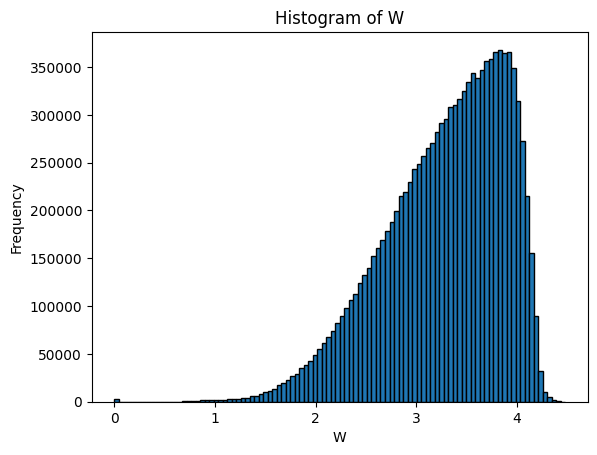

In [34]:
import matplotlib.pyplot as plt

# Assuming df_epgg is your DataFrame and "W" is your column
plt.hist(df_epgg["W"], bins=100, edgecolor='black')
plt.title("Histogram of W")
plt.xlabel("W")
plt.ylabel("Frequency")
plt.show()
